In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/fashionmnist/t10k-labels-idx1-ubyte
/kaggle/input/fashionmnist/t10k-images-idx3-ubyte
/kaggle/input/fashionmnist/fashion-mnist_test.csv
/kaggle/input/fashionmnist/fashion-mnist_train.csv
/kaggle/input/fashionmnist/train-labels-idx1-ubyte
/kaggle/input/fashionmnist/train-images-idx3-ubyte


# Import packages

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objects as go
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn import ensemble
from xgboost import XGBClassifier
import time

In [3]:
import warnings
warnings.filterwarnings(action='ignore', category=UserWarning)

# Load dataset

In [4]:
train = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
test = pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_test.csv')

In [5]:
df_train = train.copy()
df_test = test.copy()

# Examine NaN values

In [6]:
df_train.isnull().any().sum()

0

In [7]:
df_test.isnull().any().sum()

0

# Separating data and label

In [8]:
X_train= df_train.drop(['label'],axis = 1)
X_train

,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,pixel10,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,5,0,0,...,0,0,0,30,43,0,0,0,0,0
3,0,0,0,1,2,0,0,0,0,0,...,3,0,0,0,0,1,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59995,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
59996,0,0,0,0,0,0,0,0,0,0,...,73,0,0,0,0,0,0,0,0,0
59997,0,0,0,0,0,0,0,0,0,0,...,160,162,163,135,94,0,0,0,0,0
59998,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
X_train.shape

(60000, 784)

In [10]:
X_test = df_train['label']
X_test

0        2
1        9
2        6
3        0
4        3
        ..
59995    9
59996    1
59997    8
59998    8
59999    7
Name: label, Length: 60000, dtype: int64

In [11]:
X_test.shape

(60000,)

In [12]:
y_test = df_test.drop(['label'],axis = 1)
y_test.shape

(10000, 784)

# Normalization
The Pixel Values are often stored as Integer Numbers in the range 0 to 255, the range that a single 8-bit byte can offer. They need to be scaled down to [0,1] in order for Optimization Algorithms to work much faster. Here, we acheive Zero Mean and Unit Variance.

In [13]:
X_train = X_train.astype('float32')
y_test = y_test.astype('float32')
X_train /= 255.0
y_test /=255.0

# Split training and test sets 

In [14]:
seed = 99
np.random.seed(seed)
X_train, X_val, y_train, y_val = train_test_split(X_train, X_test, test_size=0.1, random_state = seed)

# Dimensionality Reduction using PCA
The advantage of PCA (and dimensionality reduction in general) is that it compresses the data down to something that is more effectively modeled. This means that it will, for example, compress away highly correlated and colinear variables, a useful thing to do when trying to run models that would otherwise be sensitive to these sort of data problems.

In [15]:
pca = PCA(n_components=100, random_state=42)
X_train_pca =pca.fit_transform(X_train)
X_test_pca = pca.transform(X_val)
y_test_pca =pca.transform(y_test)

In [16]:
X_train_pca.shape

(54000, 100)

In [17]:
X_train_PCA1 = pd.DataFrame(X_train_pca)
X_test_PCA1 = pd.DataFrame(X_test_pca)

# Evaluate the model

The algorithms which we are using for classification and analysis of the data are: 

1) Logistic Regression

2) SVM

3) Random Forest

4) Gradient Boosting

5) XGBoost

In [18]:

# 1. LR Model
start1 = time.time()

logistic = LogisticRegression(max_iter=200, solver='liblinear')
logistic.fit(X_train_PCA1, y_train)

end1 = time.time()
lr_time = end1-start1

# 2. SVC Model
start2 = time.time()

svc = SVC(C=13,kernel='rbf',gamma="auto",probability = True)
svc.fit(X_train_PCA1, y_train)

end2 = time.time()
svm_time = end2-start2

# 3. Random Forest
start3 = time.time()

random_forest = RandomForestClassifier(criterion='entropy', max_depth=70, n_estimators=100)
random_forest.fit(X_train_PCA1, y_train)

end3 = time.time()
forest_time = end3-start3

# 4. Gradient Boosting Method 
start4 = time.time()

Gradient = ensemble.GradientBoostingClassifier(n_estimators=100)
Gradient.fit(X_train_PCA1, y_train)

end4 = time.time()
gradient_time = end4-start4

# 5. XGBoost Method
start5 = time.time()

xgb = XGBClassifier(use_label_encoder=False,objective="multi:softmax",eval_metric="merror")
xgb.fit(X_train_PCA1, y_train.ravel())

end5 = time.time()
xgb_time = end5-start5


print("LR Time: {:0.2f} minute".format(lr_time/60.0))
print("SVC Time: {:0.2f} minute".format(svm_time/60.0))
print("Random Forest Time: {:0.2f} minute".format(forest_time/60.0))
print("Gradient Boosting Time: {:0.2f} minute".format(gradient_time/60.0))
print("XGBoost Time: {:0.2f} minute".format(xgb_time/60.0))

LR Time: 0.91 minute
SVC Time: 5.09 minute
Random Forest Time: 4.08 minute
Gradient Boosting Time: 41.15 minute
XGBoost Time: 9.95 minute


# Predicting the models

***Logistic Regression Report and Analysis***

In [19]:
y_train_lr = logistic.predict(X_train_PCA1)
y_pred_lr = logistic.predict(X_test_pca)
logistic_train = metrics.accuracy_score(y_train,y_train_lr )
logistic_accuracy = metrics.accuracy_score(y_val, y_pred_lr)

print("Train Accuracy score: {}".format(logistic_train))
print("Test Accuracy score: {}".format(logistic_accuracy))
print(metrics.classification_report(y_val, y_pred_lr))

Train Accuracy score: 0.8462037037037037
Test Accuracy score: 0.851
              precision    recall  f1-score   support

           0       0.80      0.83      0.81       574
           1       0.97      0.96      0.97       596
           2       0.76      0.76      0.76       573
           3       0.86      0.88      0.87       624
           4       0.77      0.78      0.78       635
           5       0.95      0.91      0.93       632
           6       0.64      0.58      0.61       600
           7       0.90      0.93      0.91       604
           8       0.92      0.93      0.93       598
           9       0.94      0.95      0.94       564

    accuracy                           0.85      6000
   macro avg       0.85      0.85      0.85      6000
weighted avg       0.85      0.85      0.85      6000



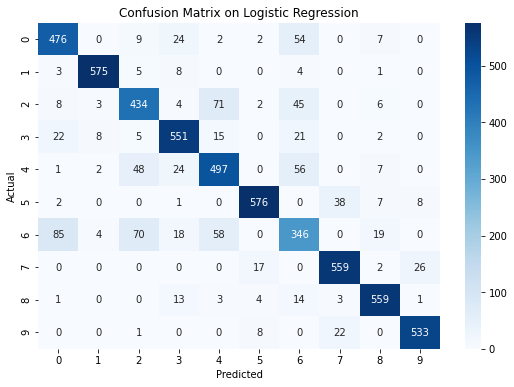

In [20]:
con_matrix = pd.crosstab(pd.Series(y_val.values.flatten(), name='Actual' ),pd.Series(y_pred_lr, name='Predicted'))
plt.figure(figsize = (9,6))
plt.title("Confusion Matrix on Logistic Regression")
sns.heatmap(con_matrix, cmap="Blues", annot=True, fmt='g')
plt.show()

***SVM Report and Analysis***

In [21]:
y_train_svc = svc.predict(X_train_PCA1)
y_pred_svc = svc.predict(X_test_pca)
svc_train = metrics.accuracy_score(y_train,y_train_svc)
svc_accuracy = metrics.accuracy_score(y_val, y_pred_svc)

print("Train Accuracy score: {}".format(svc_train))
print("Test Accuracy score: {}".format(svc_accuracy))
print(metrics.classification_report(y_val, y_pred_svc))

Train Accuracy score: 0.9425555555555556
Test Accuracy score: 0.906
              precision    recall  f1-score   support

           0       0.84      0.85      0.85       574
           1       0.99      0.98      0.99       596
           2       0.83      0.85      0.84       573
           3       0.91      0.93      0.92       624
           4       0.86      0.85      0.85       635
           5       0.98      0.95      0.96       632
           6       0.76      0.74      0.75       600
           7       0.93      0.97      0.95       604
           8       0.97      0.97      0.97       598
           9       0.97      0.96      0.96       564

    accuracy                           0.91      6000
   macro avg       0.91      0.91      0.91      6000
weighted avg       0.91      0.91      0.91      6000



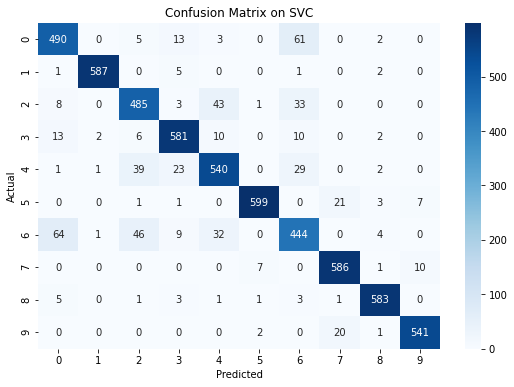

In [22]:
con_matrix = pd.crosstab(pd.Series(y_val.values.flatten(), name='Actual' ),pd.Series(y_pred_svc, name='Predicted'))
plt.figure(figsize = (9,6))
plt.title("Confusion Matrix on SVC")
sns.heatmap(con_matrix, cmap="Blues", annot=True, fmt='g')
plt.show()

***Random Forest Report and Analysis***

In [23]:
y_train_forest = random_forest.predict(X_train_PCA1)
y_pred_forest = random_forest.predict(X_test_pca)
random_forest_train = metrics.accuracy_score(y_train,y_train_forest)
random_forest_accuracy = metrics.accuracy_score(y_val, y_pred_forest)

print("Train Accuracy score: {}".format(random_forest_train))
print("Test Accuracy score: {}".format(random_forest_accuracy))
print(metrics.classification_report(y_val, y_pred_forest))

Train Accuracy score: 1.0
Test Accuracy score: 0.8748333333333334
              precision    recall  f1-score   support

           0       0.80      0.87      0.83       574
           1       1.00      0.96      0.98       596
           2       0.77      0.82      0.80       573
           3       0.88      0.91      0.90       624
           4       0.81      0.83      0.82       635
           5       0.94      0.93      0.93       632
           6       0.73      0.60      0.66       600
           7       0.92      0.94      0.93       604
           8       0.94      0.96      0.95       598
           9       0.94      0.95      0.94       564

    accuracy                           0.87      6000
   macro avg       0.87      0.87      0.87      6000
weighted avg       0.87      0.87      0.87      6000



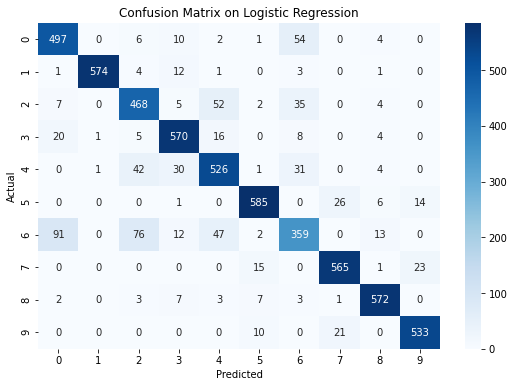

In [24]:
con_matrix = pd.crosstab(pd.Series(y_val.values.flatten(), name='Actual' ),pd.Series(y_pred_forest, name='Predicted'))
plt.figure(figsize = (9,6))
plt.title("Confusion Matrix on Logistic Regression")
sns.heatmap(con_matrix, cmap="Blues", annot=True, fmt='g')
plt.show()

***Gradient Boosting Report and Analysis***

In [25]:
y_train_gradient = Gradient.predict(X_train_PCA1)
y_pred_gradient = Gradient.predict(X_test_pca)
gradient_train = metrics.accuracy_score(y_train,y_train_gradient)
gradient_accuracy = metrics.accuracy_score(y_val, y_pred_gradient)

print("Train Accuracy score: {}".format(gradient_train))
print("Test Accuracy score: {}".format(gradient_accuracy))
print(metrics.classification_report(y_val, y_pred_gradient))

Train Accuracy score: 0.8792407407407408
Test Accuracy score: 0.859
              precision    recall  f1-score   support

           0       0.79      0.84      0.81       574
           1       0.99      0.97      0.98       596
           2       0.78      0.77      0.78       573
           3       0.85      0.88      0.87       624
           4       0.79      0.80      0.79       635
           5       0.94      0.90      0.92       632
           6       0.67      0.61      0.64       600
           7       0.91      0.93      0.92       604
           8       0.94      0.94      0.94       598
           9       0.92      0.95      0.94       564

    accuracy                           0.86      6000
   macro avg       0.86      0.86      0.86      6000
weighted avg       0.86      0.86      0.86      6000



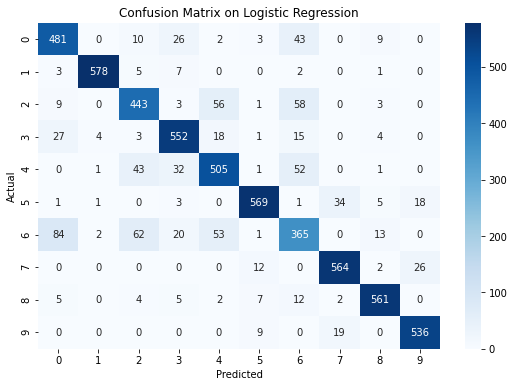

In [26]:
con_matrix = pd.crosstab(pd.Series(y_val.values.flatten(), name='Actual' ),pd.Series(y_pred_gradient, name='Predicted'))
plt.figure(figsize = (9,6))
plt.title("Confusion Matrix on Logistic Regression")
sns.heatmap(con_matrix, cmap="Blues", annot=True, fmt='g')
plt.show()

***XGBoost Report and Analysis***

In [27]:
y_train_xgboost = xgb.predict(X_train_PCA1)
y_pred_xgboost = xgb.predict(X_test_pca)
xgb_train = metrics.accuracy_score(y_train,y_train_xgboost)
xgb_accuracy = metrics.accuracy_score(y_val, y_pred_xgboost)

print("Train Accuracy score: {}".format(xgb_train))
print("Test Accuracy score: {}".format(xgb_accuracy))
print(metrics.classification_report(y_val, y_pred_xgboost))

Train Accuracy score: 0.9990370370370371
Test Accuracy score: 0.8851666666666667
              precision    recall  f1-score   support

           0       0.82      0.85      0.83       574
           1       1.00      0.97      0.99       596
           2       0.80      0.80      0.80       573
           3       0.89      0.90      0.90       624
           4       0.83      0.82      0.82       635
           5       0.97      0.94      0.95       632
           6       0.70      0.68      0.69       600
           7       0.93      0.97      0.95       604
           8       0.96      0.96      0.96       598
           9       0.96      0.96      0.96       564

    accuracy                           0.89      6000
   macro avg       0.88      0.89      0.88      6000
weighted avg       0.89      0.89      0.89      6000



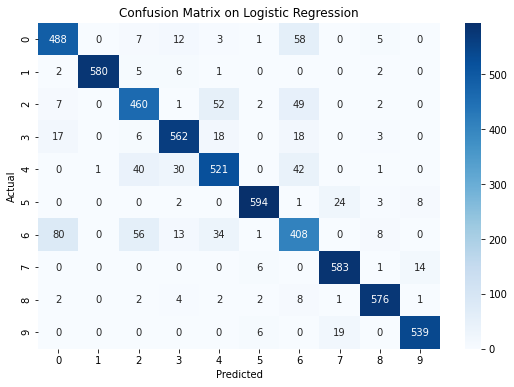

In [28]:
con_matrix = pd.crosstab(pd.Series(y_val.values.flatten(), name='Actual' ),pd.Series(y_pred_xgboost, name='Predicted'))
plt.figure(figsize = (9,6))
plt.title("Confusion Matrix on Logistic Regression")
sns.heatmap(con_matrix, cmap="Blues", annot=True, fmt='g')
plt.show()

# Model Comparison

In [29]:
Train_Accuracy = [logistic_train,svc_train,random_forest_train,gradient_train,xgb_train]
Test_Accuracy = [logistic_accuracy,svc_accuracy,random_forest_accuracy,gradient_accuracy,xgb_accuracy]
data1 = {
    'Algorithm': ['Logistic Regression','SVC','Random Forest Classifier','Gradient Boosting','XGBoost'],
    'Train Accuracy':Train_Accuracy,
    'Test Accuracy':Test_Accuracy
}

df1 = pd.DataFrame(data1)

In [30]:
df1

,Algorithm,Train Accuracy,Test Accuracy
0,Logistic Regression,0.846204,0.851000
1,SVC,0.942556,0.906000
2,Random Forest Classifier,1.000000,0.874833
3,Gradient Boosting,0.879241,0.859000
4,XGBoost,0.999037,0.885167


In [31]:
fig = go.Figure(data=[
    go.Bar(name='train set', x=data1['Algorithm'], y=data1['Train Accuracy'],text=np.round(data1['Train Accuracy'],2),textposition='outside'),
    go.Bar(name='test set', x=data1['Algorithm'], y=data1['Test Accuracy'],text=np.round(data1['Test Accuracy'],2),textposition='outside')
])

fig.update_layout(barmode='group',title_text='Accuracy Comparison On Different Models',yaxis=dict(
        title='Accuracy'))
fig.show()

# **Conclusion**

**1. **Computation Time****


# Gradient Boost>XGBoost>SVC>Random Forest>Logistic Regeression

**2. Train Accuracy**


# Random Forest>XGBoost>SVC>Gradient Boost>Logistic Regression

**3. Test Accuracy**


# SVC>XGBoost>Random Forest>Gradient Boost>Logistic Regression